In [133]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# Calibração pelo Octave

### Para calibração pelo octave um conjunto de 5 imagens foram geradas e inseridas na ferramenta.
A imagem abaixo ilustra a ferramenta identificando e extraindo pontos de referência para o cálculo dos parametros

![alt text](./octave/grid_corners.jpg "Title")

### Após a definição dos eixos de coordenadas em todas as imagens o processo de calibração foi executado. Os resultados podem ser vistos nas imagens abaixo.

![alt text](./octave/calibration_result_extrinsic_camera_centered.jpg "Title")
![alt text](./octave/calibration_result_extrinsic_world_centered.jpg)

### Os parâmetros intrinsecos foram calculados e estão exibidos abaixo.

![alt text](./octave/calibration_result_intrinsic.jpg "Title")

### Além dos parâmetros intrinsecos, também foi realizada a extração dos parâmetros extrinsecos de uma das imagens para construção de um modelo para verificar se os resultados estão consistentes.

![alt text](./octave/calibration_result_extrinsic.jpg "Title")

## Construindo um modelo com os parâmetros obtidos

In [41]:
# Auxiliar functions to homogenize coordinates

def to_homo(coord):
    return np.append(coord, 1)

def from_homo_2d(homo_coord):
    return np.array([ homo_coord[0]/homo_coord[2], homo_coord[1]/homo_coord[2] ])

def from_homo_3d(homo_coord):
    return np.array([ homo_coord[0]/homo_coord[3], homo_coord[1]/homo_coord[3], homo_coord[2]/homo_coord[3] ])

In [149]:
# Camera model class

class CameraModel:
    def __init__(self, R, T, f, c):
        self.Mint = np.array([
            [f[0], 0, c[0], 0],
            [0, f[1], c[1], 0],
            [0,  0,  1, 0]
        ])
        self.Mext = np.zeros((4,4))
        self.Mext[0:3,0:3] = R
        self.Mext[0:3,3] = T
        self.Mext[3,3] = 1

        
    def to_camera_ref(self, world_point):
        t = world_point
        if t.shape[0] == 3: #homogenize
            t = to_homo(world_point)
        homo_res = self.Mext.dot(t)
        return from_homo_3d(homo_res)        
        
    def project_world_point(self, world_point):
        t = world_point
        if t.shape[0] == 3: #homogenize
            t = to_homo(world_point)
        homo_res = self.Mint.dot(self.Mext).dot(t)
        return from_homo_2d(homo_res)
    
    def print_parameters(self):
        print('----------M int----------')
        print(self.Mint)
        print('')
        print('----------M ext----------')
        print(self.Mext)



In [151]:
## OCTAVE PARAMETERS ##
# Parameters obtained by calibration using octave are inserted below
f = np.array([1045.73, 1062.27])
c = np.array([639.50, 475.50])
R = np.array([
    [0.763311, 0.642743, -0.065099],
    [0.350098, -0.496238, -0.794468],
    [-0.542943, 0.583635, -0.603807]
])
T = np.array([ -217.467313, -51.212003, 457.262331])

octaveModel = CameraModel(R,T,f,c)
octaveModel.print_parameters()

----------M int----------
[[1.04573e+03 0.00000e+00 6.39500e+02 0.00000e+00]
 [0.00000e+00 1.06227e+03 4.75500e+02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]

----------M ext----------
[[ 7.63311000e-01  6.42743000e-01 -6.50990000e-02 -2.17467313e+02]
 [ 3.50098000e-01 -4.96238000e-01 -7.94468000e-01 -5.12120030e+01]
 [-5.42943000e-01  5.83635000e-01 -6.03807000e-01  4.57262331e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(960, 1280, 3)


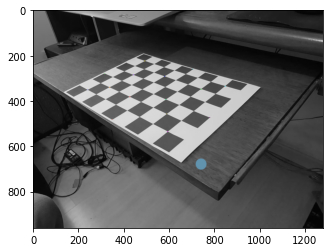

In [152]:
# Reading test image (same image the extrinsic parameters were obtained)

input_image = cv2.imread('./inputs/AnInput01.tif', cv2.IMREAD_COLOR)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
print(input_image.shape)
plt.imshow(input_image)

In [160]:
# The points selected to be used in calibration where painted with know colors, so I could extract 

points = {
    1: { 'color': np.array([255, 0, 255]), 'position': np.array([240, 30, 0])},
    2: { 'color': np.array([0, 255, 255]), 'position': np.array([240, 180, 0])},
    3: { 'color': np.array([255, 255, 0]), 'position': np.array([30, 180, 0])},
    4: { 'color': np.array([255, 127, 0]), 'position': np.array([60, 60, 0])},
    5: { 'color': np.array([255, 0, 0]), 'position': np.array([120, 60, 0])},
    6: { 'color': np.array([0, 0, 255]), 'position': np.array([120, 150, 0])},
    7: { 'color': np.array([0, 255, 0]), 'position': np.array([210, 150, 0])},
    8: { 'color': np.array([0, 255, 127]), 'position': np.array([180, 90, 0])},
    9: { 'color': np.array([127, 0, 255]), 'position': np.array([60, 120, 0])},
    10: { 'color': np.array([127, 127, 0]), 'position': np.array([210, 60, 0])},
    11: { 'color': np.array([127, 127, 255]), 'position': np.array([30, 30, 0])},
    12: { 'color': np.array([255, 127, 127]), 'position': np.array([150, 0, 0])},
    13: { 'color': np.array([0, 127, 127]), 'position': np.array([150, 270, 0])},
    14: { 'color': np.array([127, 255, 127]), 'position': np.array([0, 90, 0])},
    15: { 'color': np.array([127, 0, 255]), 'position': np.array([270, 90, 0])}
}

In [161]:

def find_color_position(input_image, color):  
    h, w, c = input_image.shape
    acc_h = 0
    acc_w = 0
    total = 0
    for i_h in range(h):
        for i_w in range(w):
            if np.array_equal(input_image[i_h,i_w], color):
                acc_h = acc_h + i_h
                acc_w = acc_w + i_w
                total = total + 1
    if total > 0:
        pos_h = int(acc_h/total)
        pos_w = int(acc_w/total)
    return np.array([pos_w, pos_h]) # Troca posições para manter X e Y ao invés de linha coluna

point = 7
color = points[point]['color']
image_coord = find_color_position(input_image, color)
world_coord = points[point]['position']



---- Sampling point ----
7 - (742, 348) <- (210mm, 150mm, 0mm)
Checking consistency with model obtained from octave parameters
    (735, 347)


In [163]:
for point in points.keys():
    
    color = points[point]['color']
    image_coord = find_color_position(input_image, color)
    world_coord = points[point]['position']
    print(world_coord, image_coord)
    #print(image_coord)
    #image_coords.append(image_coord)
    #world_coords.append(world_coord)
#A = np.array(A)

[240  30   0] [594 535]
[240 180   0] [848 335]
[ 30 180   0] [493 224]
[60 60  0] [338 340]
[120  60   0] [427 382]
[120 150   0] [581 291]
[210 150   0] [742 348]
[180  90   0] [586 393]
[ 60 120   0] [444 285]
[210  60   0] [590 457]
[30 30  0] [241 351]
[150   0   0] [349 482]
[150 270   0] [705 260]
[ 0 90  0] [316 280]
[270  90   0] [444 285]


In [165]:
# Data manually collected from our sample image
# Columns 0:3 -> point in World Coordinates (3D)
# Columns 3:5 -> point in Image Coordinates (2D)
world = [0,1,2]
image = [3, 4]

data = np.array([
    [240,30,0,594,535],
    [240,180,0,848,335],
    [30,180,0,493,224],
    [60,60,0,338,340],
    [120,60,0,427,382],
    [120,150,0,581,291],
    [210,150,0,742,348],
    [180,90,0,586,393],
    [60,120,0,444,285],
    [210,60,0,590,457],
    [30,30,0,241,351],
    [150,0,0,349,482],
    [150,270,0,705,260],
    [0,90,0,316,280],
    [270,90,0,444,285]
])

In [183]:
for i in range(len(data)):
    wrld = data[i, world]
    img = data[i, image]
    proj = octaveModel.project_world_point(wrld)
    error = img - proj
    print('Sample {:<2} ({:<3}mm, {:<3}mm, {:<3}mm) -> \t {:.2f}, {:.2f} \t  {:.2f}, {:.2f} \t  Err. ({:.2f}, {:.2f}) '.format(
        i, 
        wrld[0], wrld[1], wrld[2], 
        proj[0], proj[1],
        img[0], img[1],
        error[0], error[1]
    ))       


Sample 0  (240mm, 30 mm, 0  mm) -> 	 593.99, 530.78 	  594.00, 535.00 	  Err. (0.01, 4.22) 
Sample 1  (240mm, 180mm, 0  mm) -> 	 836.59, 336.54 	  848.00, 335.00 	  Err. (11.41, -1.54) 
Sample 2  (30 mm, 180mm, 0  mm) -> 	 488.44, 222.53 	  493.00, 224.00 	  Err. (4.56, 1.47) 
Sample 3  (60 mm, 60 mm, 0  mm) -> 	 336.72, 336.90 	  338.00, 340.00 	  Err. (1.28, 3.10) 
Sample 4  (120mm, 60 mm, 0  mm) -> 	 425.75, 378.57 	  427.00, 382.00 	  Err. (1.25, 3.43) 
Sample 5  (120mm, 150mm, 0  mm) -> 	 575.28, 290.28 	  581.00, 291.00 	  Err. (5.72, 0.72) 
Sample 6  (210mm, 150mm, 0  mm) -> 	 734.75, 346.96 	  742.00, 348.00 	  Err. (7.25, 1.04) 
Sample 7  (180mm, 90 mm, 0  mm) -> 	 583.10, 390.80 	  586.00, 393.00 	  Err. (2.90, 2.20) 
Sample 8  (60 mm, 120mm, 0  mm) -> 	 439.66, 282.78 	  444.00, 285.00 	  Err. (4.34, 2.22) 
Sample 9  (210mm, 60 mm, 0  mm) -> 	 588.06, 454.53 	  590.00, 457.00 	  Err. (1.94, 2.47) 
Sample 10 (30 mm, 30 mm, 0  mm) -> 	 239.70, 346.69 	  241.00, 351.00 	  Err. 

# Calibração utilizando o algoritmo do livro Trucco e Verri

![alt text](./trucco/data_points.png "Title")

A imagem acima ilustra a imagem tomada para a realização da calibração.

Importante notar que alterei o padrão para que ao invés de um plano os pontos de calibração pudessem ser extraidos das faces de um cubo.

Em amarelo os pontos coletados.

## Entradas e configuração

In [137]:
# CONFIGURATION

# Since TRUCCO/VERRI algorithm assume that the image origin is in the center or the image
# original image coordinates should be translated to keep consistency
image_center_is_origin = True

force_rotation_matrix_orthogonal = True

In [138]:
# INPUTS

# Define the center of the image
y0 = 1280/2
x0 = 960/2 

# Data manually collected from our sample image
# Columns 0:3 -> point in World Coordinates (3D)
# Columns 3:5 -> point in Image Coordinates (2D)
world = [0,1,2]
image = [3, 4]

data = np.array([
    [0,0,0,485,895],
    [90,0,0, 628, 773],
    [0,0,30, 477, 845],
    [30,0,30, 532, 801],
    [150, 0, 60, 710, 602],
    [120, 0, 90, 670, 574],
    [60, 0, 90, 573, 648],
    [90, 0, 60, 624, 665],                 
    [0,0,120, 456, 666],
    [0,30, 0, 431, 854],
    [0, 60, 120, 343, 599],
    [0,60,60, 363, 722],
    [0, 120, 90, 256, 607],
    [0, 90,30, 327, 740],
    [30, 30, 120, 460, 589],
    [90, 90, 120, 464, 489],
    [60, 30, 120, 515, 557],
    [30, 60, 120, 405, 559],
    [0, 90, 120, 295, 569],
    [60, 90, 120, 413, 509]
])

if image_center_is_origin: # transforma x = x - ox
    data[:,4] = data[:,4] - y0
    data[:,3] = data[:,3] - x0
    # print(data)


In [139]:
# AUXILIAR FUNCTIONS
# Functions below are helpers to build matrices used by the algorithm 

def format_row_AS1(i, w):
    return np.array([
        i[0]*w[0],
        i[0]*w[1],
        i[0]*w[2],
        i[0],
        -i[1]*w[0],
        -i[1]*w[1],
        -i[1]*w[2],
        -i[1],
    ])

def format_row_AS2(i, w, R, T):
    return np.array([ 
        i[0],
        R[0,0]*w[0]+R[0,1]*w[1]+R[0,2]*w[2] + T[0]
    ])


def format_row_bS2(i, w, R):
    return np.array([ 
        -i[0]*(R[2,0]*w[0]+R[2,1]*w[1]+R[2,2]*w[2])
    ])


## O algoritmo

In [140]:
# THE ALGORITHM

# Build Matrix A
A = np.array([format_row_AS1(data[i,image], data[i,world]) for i in range(len(data))])

# Perform Single Values Decomposition
U, S, Vt = np.linalg.svd(A)

# Since values are sorted, last column will represent to the smallest eigenvalue 
v = Vt.T[:, -1]

# Calculate scale factor 
gamma = np.sqrt( pow(v[0],2) + pow(v[1],2) + pow(v[2],2) )

# Calculate aspect ratio
alpha = np.sqrt( pow(v[4],2) + pow(v[5],2) + pow(v[6],2) ) / gamma

# Adjust estimated parameters by the scale factor
v = v / gamma

# Build R matrix (Rotation)
R = np.zeros((3,3))
R[1,:] = v[0:3]
R[0,:] = v[4:7]/alpha
R[2,:] = np.cross(R[0,:],R[1,:])

# Partially build T vector (Translation)
T = np.zeros(3)
T[1] = v[3]
T[0] = v[7]/alpha
# print(T)

# Check and adjust scale factor signal (if necessary)
st = data[0,image][0] * (R[0,0]*data[0, world][0] + R[0,1]*data[0, world][0] + R[0,2]*data[0, world][0] + T[0])
if st > 0:
    R[1,:] = -R[1,:]
    R[0,:] = -R[0,:]
    T = -T

# If configured to do so, force rotation matrix to be orthogonal
U, s, V = np.linalg.svd(R)
if force_rotation_matrix_orthogonal: #Forçar a ortogonalidade de R
    R = U.dot(np.eye(3,3).dot(V))
    
# Build system to solve for Tz and fx
Afinal = np.array([format_row_AS2(data[i, image], data[i, world], R, T) for i in range(len(data))])
Bfinal = np.array([format_row_bS2(data[i, image], data[i, world], R) for i in range(len(data))])

# Find final parameters Tz and fx
tf = np.linalg.inv(Afinal.T.dot(Afinal)).dot(Afinal.T).dot(Bfinal)
T[2] = tf[0]
f = np.ones(2) * tf[1] 


In [142]:
# Shoud place principal point in origin since Trucco and Verri book algorithm assumes that.
# The input data was also previously translated
c = np.array([0, 0])

# Changing the [fx, fy] signal to fit the model as described in Trucco and Verri book
svdCalibration = CameraModel(R,T,-f,c)

# Selecting a sample to check the model
sample_idx = 3
predicted_coordinates = svdCalibration.project_world_point(data[sample_idx,0:3])
true_coordinates = data[sample_idx,3:5]

print('')
print('Predicted Coordinates: {}'.format(predicted_coordinates))
print('Actual coordinates: {}'.format(true_coordinates))
print('Error: {}'.format(true_coordinates - predicted_coordinates))


Predicted Coordinates: [ 50.32734642 160.95791557]
Actual coordinates: [ 52 161]
Error: [1.67265358 0.04208443]


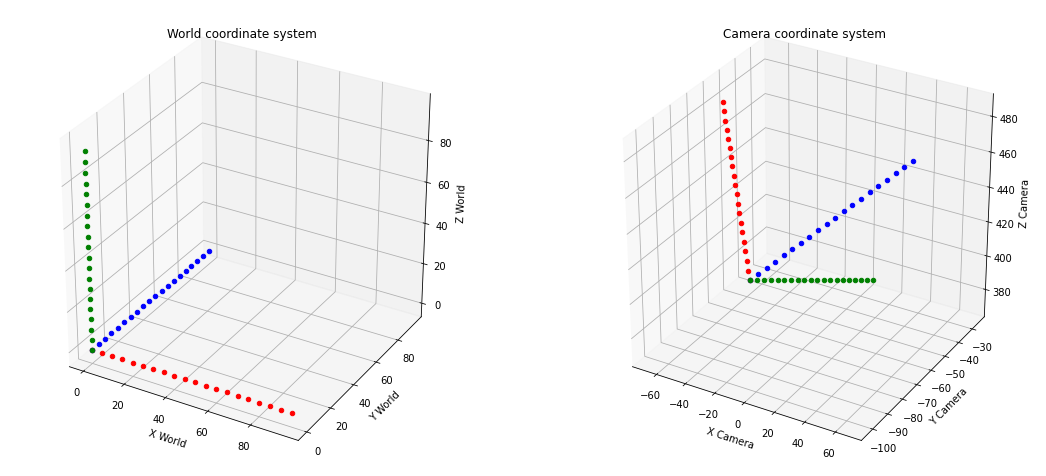

In [146]:
# The code below was used for debuging. A visualization of how point in world
# coordinate system are projected to camera coordinate system

axis_test_x = np.array([ [i*5, 0, 0] for i in range(20) ])
axis_test_y = np.array([ [0, i*5, 0] for i in range(20) ]) 
axis_test_z = np.array([ [0, 0, i*5] for i in range(20) ])

fig = plt.figure()
fig.set_size_inches(18.5, 8.5)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

for i in range(len(axis_test_x)):
    src = axis_test_x[i]
    trg = svdCalibration.to_camera_ref(axis_test_x[i])
    ax2.scatter(trg[0], trg[1], trg[2], color='r')
    ax1.scatter(src[0], src[1], src[2], color='r')
    
for i in range(len(axis_test_y)):
    src = axis_test_y[i]
    trg = svdCalibration.to_camera_ref(axis_test_y[i])
    ax2.scatter(trg[0], trg[1], trg[2], color='b')
    ax1.scatter(src[0], src[1], src[2], color='b')
    
for i in range(len(axis_test_z)):
    src = axis_test_z[i]
    trg = svdCalibration.to_camera_ref(axis_test_z[i])
    ax2.scatter(trg[0], trg[1], trg[2], color='g')
    ax1.scatter(src[0], src[1], src[2], color='g')

ax1.set_title('World coordinate system')
ax1.set_xlabel('X World')
ax1.set_ylabel('Y World')
ax1.set_zlabel('Z World')

ax2.set_title('Camera coordinate system')
ax2.set_xlabel('X Camera')
ax2.set_ylabel('Y Camera')
ax2.set_zlabel('Z Camera')

plt.show()
